# Exploratory Data Analysis

&lt; Work in progress &gt;

__TODO / MISSING__:
* Add hour of day to comments for further exploration
* Add day of week to comments
* Class distribution: use histograms instead of size()
* Scatter plots
* Violin plots


In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Not necessary, but I like the ggplot style better
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_08.csv')
df_com = pd.read_csv('comments_2017_08.csv')
# Make float better readable
pd.options.display.float_format = '{:.0f}'.format

### First Look

In [3]:
df_art.head(3)

,tId,article_id,updated,num_comments,link,header,sub,text
0,30600370,30600370,1502015309,12,/leben/reisen/story/Fuenf-Gruende-fuer-eine-Re...,Fünf Gründe für eine Reise nach Alabama,Sweet Home Alabama! Der Staat im Südosten der ...,"Feinste Sandstrände, kilometerlange Maisfelder..."
1,11684042,11684042,1502015306,4,/ausland/news/story/Lopez-aus-Gefaengnis-in-Ha...,Lopez aus Gefängnis in Hausarrest entlassen,Vier Tage nach seiner Festnahme befindet sich ...,Vier Tage nach seiner Festnahme ist der venezo...
2,29297244,29297244,1502015324,39,/sport/weitere/story/29297244,Buhmann Gatlin holt Gold – Bolt wird gefeiert,Usain Bolt muss auf seine 12. WM-Goldmedaille ...,(sr/fal/sda)


In [4]:
df_com.head(3)

,tId,cId,mob,vup,vdo,tit,aut,time,con
0,30284249,329_485,1,5,2,@Rebby,Störenfried,am 06.08.2017 08:59,"Wäre doch machbar, Störsender in Autos einzub..."
1,25420673,1_37,1,0,0,@T. Paul,Papa Bär,am 05.08.2017 22:02,Hier. Aber ich bin ja nur ein Papa Bär. Hüte ...
2,30284249,47_47,1,39,7,Das liebe Handy...,Heinz,am 05.08.2017 19:00,Und dazu brauchts ne Studie? Legt im allgemei...


In [5]:
print(df_art.shape)
print(df_com.shape)

(21, 8)
(1307, 9)


In [6]:
print(df_art.dtypes)
print(' ')
print(df_com.dtypes)

tId               int64
article_id        int64
updated         float64
num_comments      int64
link             object
header           object
sub              object
text             object
dtype: object
 
tId      int64
cId     object
mob      int64
vup      int64
vdo      int64
tit     object
aut     object
time    object
con     object
dtype: object


In [7]:
df_art.describe()

# Summary:
# No missing attributes since count is the same everywhere
# No negative values, chi^2 etc. can be used

,tId,article_id,updated,num_comments
count,21,21,21,21
mean,21993259,21993259,1502015317,63
std,6324191,6324191,8,95
min,11684042,11684042,1502015306,0
25%,15904700,15904700,1502015309,6
50%,22101669,22101669,1502015316,16
75%,26624359,26624359,1502015325,39
max,30715052,30715052,1502015328,296


In [8]:
df_com.describe()

# Summary:
# No missing attributes 
# No negative values

,tId,mob,vup,vdo
count,1307,1307,1307,1307
mean,19864521,1,40,19
std,6589672,0,69,36
min,11684042,0,0,0
25%,13942829,0,8,3
50%,19423348,1,22,8
75%,25420673,1,46,18
max,30715052,1,969,316


In [9]:
print(df_art.skew())
# Makes only sense on 'num_comments'

tId            -0
article_id     -0
updated         0
num_comments    2
dtype: float64


In [10]:
print(df_com.skew())
# Skew is not high enough that it has to be corrected

tId    0
cId    1
mob   -1
vup    7
vdo    4
dtype: float64


### Feature Engineering
To make further analysis possible concerning time features.

In [55]:
from datetime import datetime

def get_dt_obj(time):
    time = time.replace('am ', '')
    # Make datetime object from string
    return datetime.strptime(time, '%d.%m.%Y %H:%M')

def get_hour_of_day(time):
    return get_dt_obj(time).hour

def get_weekday(time):
    return get_dt_obj(time).weekday()

# Basically same as "the hour of week" or "weekday_hourOfDay"
def get_weekday_float(time):
    hour = float(get_hour_of_day(time))
    weekday = get_weekday(time)
    return float(weekday) + hour / 24

def get_weekday_hour(time):
    return '{}_{}'.format(get_weekday(time), get_hour_of_day(time))

df_com['hour'] = df_com['time'].apply(get_hour_of_day)
df_com['weekday'] = df_com['time'].apply(get_weekday) # 0 = Monday
df_com['weekday_fl'] = df_com['time'].apply(get_weekday_float)
df_com['weekday_hour'] = df_com['time'].apply(get_weekday_hour)
df_com['score'] = df_com['vup'] - df_com['vdo']

### Class Distribution

In [12]:
# 'df_art' has no classes

# 'df_com' 
print(df_com.groupby('mob').size())
print(df_com.groupby('hour').size())
print(df_com.groupby('weekday').size())

mob
0    334
1    973
dtype: int64
hour
0      33
1      26
2      12
3       7
4      15
5      29
6      58
7      62
8      74
9      63
10     60
11     33
12     55
13     13
14     15
15     18
16     31
17     32
18     67
19    149
20    108
21     87
22    130
23    130
dtype: int64
weekday
0     82
1      2
2    102
3    311
4     84
5    300
6    426
dtype: int64


### Correlation
Let's find relations between some of the attributes. Correlation requires continuous data.

In [54]:
# Only for these columns
cols = ['hour', 'weekday', 'weekday_fl', 'mob', 'vup', 'vdo']

# Change back how float is displayed
pd.options.display.float_format = '{:.4f}'.format

# Get pearson co-efficients
df_corr = df_com[cols].corr()
df_corr

# Summary:
# Correlations are low.
# The only interesting correlation is between 'vup' and 'vdo'.

,hour,weekday,weekday_fl,mob,vup,vdo
hour,1.0000,0.1547,0.3063,0.0045,0.1775,0.1863
weekday,0.1547,1.0000,0.9879,-0.0820,0.1056,0.1118
weekday_fl,0.3063,0.9879,1.0000,-0.0783,0.1297,0.1370
mob,0.0045,-0.0820,-0.0783,1.0000,0.0309,0.0959
vup,0.1775,0.1056,0.1297,0.0309,1.0000,0.2797
vdo,0.1863,0.1118,0.1370,0.0959,0.2797,1.0000


### Scatter plot

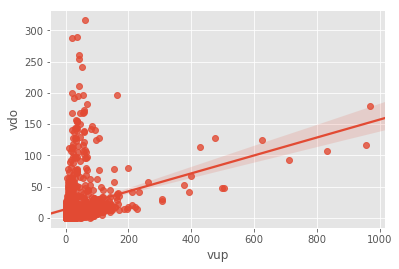

In [14]:
#sns.pairplot(df_com, x_vars='vup', y_vars='vdo', size=6)
sns.regplot(x='vup', y='vdo', data=df_com)
plt.show()

# Quite some outliers

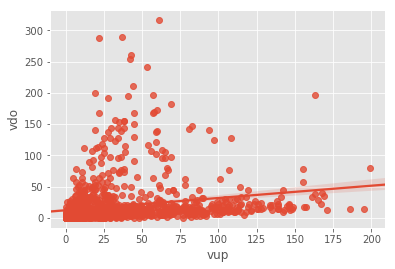

In [15]:
sns.regplot(x='vup', y='vdo', data=df_com[df_com['vup'] < 200])
plt.show()

### Prediction
Ok... I want to know:
* How to get the best score/consensus (upvotes - downvotes)?
* How to be most controversial (upvotes + downvotes)?
* Which articles go most score / were most controversial (sum over all comments)?

Impact will be taken into account from:
* Hour of comment
* Weekday
* Weekday + hour = Hour of week
* text written
* title written / if title is an answer (starts with "@")
* if from mobile (makes no sense, but let's see what happens)
* article text
* article category
* ...?

Empty DataFrame
Columns: [tId, cId, mob, vup, vdo, tit, aut, time, con, hour, weekday, weekday_fl, score, contr, weekday_hour, article_id, updated, num_comments, link, header, sub, text]
Index: []

[0 rows x 22 columns]


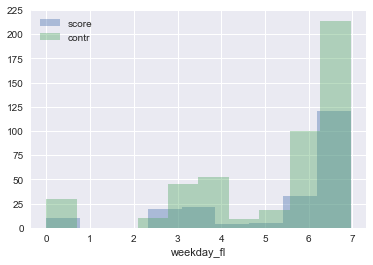

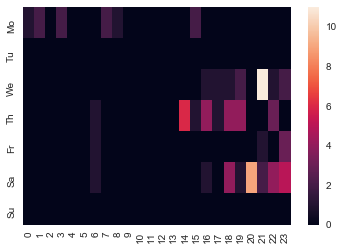

In [169]:
df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['contr'] = df_com['vup'] + df_com['vdo']
df_com['tit'] = df_com['tit'].str.lower()
df_com['con'] = df_com['con'].str.lower()
# Left inner join
df_merge = pd.merge(left=df_com, right=df_art, left_on='tId', right_on='tId')

# is empty: (= all comments correspond to an article)
print(df_merge[pd.isnull(df_merge['text'])])
#print(df_com.shape)
#print(df_merge.shape)

sns.set(color_codes=True)
ax = sns.distplot(df_com[df_com['score']>50]['weekday_fl'], label='score', kde=False)
ax = sns.distplot(df_com[df_com['contr']>50]['weekday_fl'], label='contr', kde=False)
ax.legend()
plt.show()
grouped = df_com[df_com['score']>50].groupby(['weekday', 'hour']).size()
matrix = np.zeros((7, 24))
for d in range(0, 6):
    for h in range(0, 24):
        if d in grouped and h in grouped[d]:
            matrix[d][h] = grouped[d][h]

weekdays = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
sns.heatmap(matrix, yticklabels=weekdays)
plt.show()

# 0 = Monday, 7 = Sunday
# Summary:
# The day and time of posting plays a big role
# This is probably because on Sunday (7) upvoting people are most active
# This does not mean that posting the *same* comment on those times gives you more upvotes
# - it may be possible, but we can't imply that (yet?)

In [167]:
# TODO make test set

# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für"
stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns"
stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier"
stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

# Prepare data for X and y
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(min_df=5, ngram_range=(1, 1), stop_words=stop_words) # Range higher than 1 doesn't help
X_train_counts = vect.fit_transform(df_merge['con'])

y_scaler = StandardScaler()
def classify(val):
    if val > 100: return 1
    return 0

y_train = df_merge['contr'].apply(classify)
#y_train = y_scaler.fit_transform(df_merge['score'][:, None])
#y_test = y.scaler.transform(y_test)

from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Get best parameter
from sklearn.model_selection import GridSearchCV
param_grid = {'C': np.logspace(-3, 1, 5)}#, 'gamma': np.logspace(-2, 1, 4)}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train_counts, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

# Summary:
# Removing stop words didn't help the score, but it makes the model easier to interpret
# N-gram over 1 don't make a better score
# Threshold > 100 for classification gives a better prediction than for > 50

Best cross-validation score: 0.84
Best parameters:  {'C': 0.10000000000000001}


In [162]:
 # Run to understand how coefficients are set / which words are important
logreg = LogisticRegression(C=1e-1)
logreg.fit(X_train_counts, y_train)
coeff_by_name = {}
for i, f in enumerate(vect.get_feature_names()):
    coeff_by_name[f] = logreg.coef_[:, i][0]

coeff_sorted = sorted(coeff_by_name.items(), key=lambda x:x[1], reverse=True)

for c in coeff_sorted[0:20]:
    print("{}\t{}".format(c[0], c[1]))
print("----------")
for c in coeff_sorted[-20:]:
    print("{}\t{}".format(c[0], c[1]))

# Summary:
# 

spieler	0.5318294231159343
müde	0.4948710721932407
er	0.44959874884033896
fcb	0.4471037698083674
delgado	0.42285311621393196
saison	0.3267895622686214
gute	0.31309319771489236
für	0.30557387738356073
schweizer	0.30306275798906607
mal	0.29949845035105993
hätte	0.28403045356322154
dieses	0.28105256423390945
politisch	0.27759524317611955
unser	0.2748961390489468
uns	0.2737363554404144
basel	0.2693679570685962
spielen	0.2668408674483416
ihr	0.254372890974328
alles	0.25314086720983114
endlich	0.25118524590168206
----------
zur	-0.19745726575935055
glück	-0.19822427066096715
werden	-0.20453794173743423
will	-0.2065954283133876
als	-0.21266890343991124
das	-0.2189658886011098
wenn	-0.22098074738763854
halt	-0.23057837312747723
frage	-0.2341547874428746
asteroiden	-0.23864672327291458
damit	-0.2411670644595318
wäre	-0.24539669073738715
bis	-0.25167861149255927
viel	-0.2590251587563156
alle	-0.2701871408157392
sollte	-0.2727911525868929
du	-0.27795290323239424
im	-0.2781871856778606
aber	-0.295

In [168]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
y_train = df_merge['score']
grid.fit(df_merge['con'], y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("best params: ", grid.best_params_)


Best cross-validation score: 0.04
best params:  {'logisticregression__C': 0.001}


1433


AttributeError: 'LogisticRegression' object has no attribute 'named_steps'